In [1]:
%matplotlib inline
import os
import time
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from tqdm import trange
from jax import jvp, value_and_grad
from flax import linen as nn
from typing import Sequence
from functools import partial

In [2]:
def gaussian(alpha):
    phi = jnp.exp(-1 * alpha**2)
    return phi
def linear(alpha):
    return alpha
# Define the RBF module using FLAX
class RBF(nn.Module):
    
    out_features: int
    basis_func: callable

    @nn.compact
    def __call__(self, input):
        # Initialize learnable parameters
        centres = self.param('centres', nn.initializers.normal(), (self.out_features, 1))
        log_sigmas = self.param('log_sigmas', nn.initializers.constant(0.001), (self.out_features,))

        # Compute distances
        x = jnp.expand_dims(input, axis=1)
        c = jnp.expand_dims(centres, axis=0)
        distances = jnp.sqrt(jnp.sum((x - c)**2, axis=-1)) / jnp.exp(log_sigmas)

        # Apply radial basis function
        return self.basis_func(distances)

## 1. SPINN

In [3]:
# forward function
class CPPINN(nn.Module):
    features: Sequence[int]
 
    #bases = [bases_x,bases_y,bases_z]
    @nn.compact
    def __call__(self, x, y, z):
        inputs, outputs = [x, y, z], []
        init = nn.initializers.xavier_normal()
        for X in inputs:
            for fs in self.features[:-1]:
                X = nn.Dense(fs, kernel_init=init)(X)
                X = nn.activation.tanh(X)
            X = nn.Dense(self.features[-1], kernel_init=init)(X)
            
            outputs += [jnp.transpose(X, (1, 0))]

        xy = jnp.einsum('fx, fy->fxy', outputs[0], outputs[1])
        return jnp.einsum('fxy, fz->xyz', xy, outputs[-1])
    
class TTPINN(nn.Module):
    features: Sequence[int]
 
    #bases = [bases_x,bases_y,bases_z]
    @nn.compact
    def __call__(self, x, y, z):
        inputs, outputs = [x, y, z], []
        init = nn.initializers.xavier_uniform()
        for i,X in enumerate(inputs):
            for fs in self.features[:-1]:
                X = nn.Dense(fs, kernel_init=init)(X)
                X = nn.activation.tanh(X)
            if i==0:
                X = nn.DenseGeneral((self.features[-1],self.features[-1]), kernel_init=init)(X)
                
            else:
                X = nn.Dense(self.features[-1], kernel_init=init)(X)
            outputs += [X]
                
        #mid = jnp.einsum('ij,kj->ikj', outputs[1][:self.features[-1]], outputs[1][self.features[-1]:])
        #print(mid.shape)
        #mid = jnp.einsum('fx,ky->fyk',outputs[0],outputs[1])
        #xyz = jnp.einsum('fx, fy,fz->xyz', outputs[0], outputs[1],outputs[-1])
        return jnp.einsum('xfk,yf,zk->xyz',outputs[0],outputs[1],outputs[-1])

    
class TuckerPINN(nn.Module):
    features: Sequence[int]
 
    def setup(self):
        # Initialize learnable parameters
        #self.centres = self.param('centres', nn.initializers.uniform(1.01), (self.out_features, 1))
        self.core = self.param("core",nn.initializers.orthogonal(),(self.features[-1],self.features[-1],self.features[-1]))

    @nn.compact
    def __call__(self, x, y, z):
        inputs, outputs = [x, y, z], []
        init = nn.initializers.xavier_normal()
        for X in inputs:
            for fs in self.features[:-1]:
                X = nn.Dense(fs, kernel_init=init)(X)
                X = nn.activation.tanh(X)
            X = nn.Dense(self.features[-1], kernel_init=init)(X)
            
            outputs += [jnp.transpose(X, (1, 0))]
            #mid = jnp.einsum("fx,fy->fxy",outputs[0],outputs[1])
        return jnp.einsum("klm,kx,ly,mz->xyz",self.core,outputs[0],outputs[1],outputs[-1])
    
    
    
class RBFPINN(nn.Module):
    #features: Sequence[int]
    out_features: int
    basis_func: callable
    centers_x = jnp.linspace(-0.1,10.1,64).reshape((64,1))
    centers_y = jnp.linspace(-1.1,1.1,64).reshape((64,1))
    centers_z = jnp.linspace(-1.1,1.1,64).reshape((64,1))
    all_centres = [centers_x,centers_y,centers_z]

    def setup(self):
        # Initialize learnable parameters
        #self.centres = self.param('centres', nn.initializers.uniform(1.01), (self.out_features, 1))
        self.log_sigmas = self.param('log_sigmas', nn.initializers.constant(0.0), (self.out_features,))

    @nn.compact
    def __call__(self, x, y, z):
        # Normalize input data
        #x = self.normalize(x,0,10)
        #print(x)
        #y = self.normalize(y,-1,2)
        #z = self.normalize(z,-1,2)

        inputs, outputs = [x, y, z], []
        init = nn.initializers.xavier_normal()
        for X,centres in zip(inputs,self.all_centres):
            # Compute distances
            x = jnp.expand_dims(X, axis=1)
            c = jnp.expand_dims(centres, axis=0)
            distances = jnp.sqrt(jnp.sum((x - c)**2, axis=-1)) / jnp.exp(self.log_sigmas)
            # Apply radial basis function
            X = self.basis_func(distances)
            #X = nn.Dense(self.out_features, kernel_init=init)(X)
            print(X)
            outputs += [jnp.transpose(X, (1, 0))]
        xy = jnp.einsum('fx, fy->fxy', outputs[0], outputs[-1])
        return jnp.einsum('fxy, fz->xyz', xy, outputs[1])

    def normalize(self, data,mean,std):
        # Normalize data
        #mean = jnp.mean(data, axis=0)
        #std = jnp.std(data, axis=0)
        normalized_data = (data - mean) / std
        return normalized_data
        
    

# hessian-vector product
def hvp_fwdfwd(f, primals, tangents, return_primals=False):
    g = lambda primals: jvp(f, (primals,), tangents)[1]
    primals_out, tangents_out = jvp(g, primals, tangents)
    if return_primals:
        return primals_out, tangents_out
    else:
        return tangents_out


# loss function
def spinn_loss_klein_gordon3d(apply_fn, *train_data):
    def residual_loss(params, t, x, y, source_term):
        # calculate u
        u = apply_fn(params, t, x, y)
        # tangent vector dx/dx
        # assumes t, x, y have same shape (very important)
        v = jnp.ones(t.shape)
        # 2nd derivatives of u
        utt = hvp_fwdfwd(lambda t: apply_fn(params, t, x, y), (t,), (v,))
        uxx = hvp_fwdfwd(lambda x: apply_fn(params, t, x, y), (x,), (v,))
        uyy = hvp_fwdfwd(lambda y: apply_fn(params, t, x, y), (y,), (v,))
        return jnp.mean((utt - uxx - uyy + u**2 - source_term)**2)

    def initial_loss(params, t, x, y, u):
        return jnp.mean((apply_fn(params, t, x, y) - u)**2)

    def boundary_loss(params, t, x, y, u):
        loss = 0.
        for i in range(4):
            loss += (1/4.) * jnp.mean((apply_fn(params, t[i], x[i], y[i]) - u[i])**2)
        return loss

    # unpack data
    tc, xc, yc, uc, ti, xi, yi, ui, tb, xb, yb, ub = train_data

    # isolate loss function from redundant arguments
    fn = lambda params: residual_loss(params, tc, xc, yc, uc) + \
                        initial_loss(params, ti, xi, yi, ui) + \
                        boundary_loss(params, tb, xb, yb, ub)

    return fn


# optimizer step function
@partial(jax.jit, static_argnums=(0,))
def update_model(optim, gradient, params, state):
    updates, state = optim.update(gradient, state)
    params = optax.apply_updates(params, updates)
    return params, state

2024-05-31 09:03:34.751185: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## 2. Data generator

In [4]:
# 2d time-dependent klein-gordon exact u
def _klein_gordon3d_exact_u(t, x, y):
    return (x + y) * jnp.cos(2*t) + (x * y) * jnp.sin(2*t)


# 2d time-dependent klein-gordon source term
def _klein_gordon3d_source_term(t, x, y):
    u = _klein_gordon3d_exact_u(t, x, y)
    return u**2 - 4*u


# train data
def spinn_train_generator_klein_gordon3d(nc, key):
    keys = jax.random.split(key, 3)
    # collocation points
    tc = jax.random.uniform(keys[0], (nc, 1), minval=0., maxval=10.)
    xc = jax.random.uniform(keys[1], (nc, 1), minval=-1., maxval=1.)
    yc = jax.random.uniform(keys[2], (nc, 1), minval=-1., maxval=1.)
    tc_mesh, xc_mesh, yc_mesh = jnp.meshgrid(tc.ravel(), xc.ravel(), yc.ravel(), indexing='ij')
    uc = _klein_gordon3d_source_term(tc_mesh, xc_mesh, yc_mesh)
    # initial points
    ti = jnp.zeros((1, 1))
    xi = xc
    yi = yc
    ti_mesh, xi_mesh, yi_mesh = jnp.meshgrid(ti.ravel(), xi.ravel(), yi.ravel(), indexing='ij')
    ui = _klein_gordon3d_exact_u(ti_mesh, xi_mesh, yi_mesh)
    # boundary points (hard-coded)
    tb = [tc, tc, tc, tc]
    xb = [jnp.array([[-1.]]), jnp.array([[1.]]), xc, xc]
    yb = [yc, yc, jnp.array([[-1.]]), jnp.array([[1.]])]
    ub = []
    for i in range(4):
        tb_mesh, xb_mesh, yb_mesh = jnp.meshgrid(tb[i].ravel(), xb[i].ravel(), yb[i].ravel(), indexing='ij')
        ub += [_klein_gordon3d_exact_u(tb_mesh, xb_mesh, yb_mesh)]
    return tc, xc, yc, uc, ti, xi, yi, ui, tb, xb, yb, ub


# test data
def spinn_test_generator_klein_gordon3d(nc_test):
    t = jnp.linspace(0, 10, nc_test)
    x = jnp.linspace(-1, 1, nc_test)
    y = jnp.linspace(-1, 1, nc_test)
    t = jax.lax.stop_gradient(t)
    x = jax.lax.stop_gradient(x)
    y = jax.lax.stop_gradient(y)
    tm, xm, ym = jnp.meshgrid(t, x, y, indexing='ij')
    u_gt = _klein_gordon3d_exact_u(tm, xm, ym)
    t = t.reshape(-1, 1)
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    return t, x, y, u_gt, tm, xm, ym

## 3. Utils

In [5]:
def relative_l2(u, u_gt):
    return jnp.linalg.norm(u-u_gt) / jnp.linalg.norm(u_gt)

def plot_klein_gordon3d(t, x, y, u):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    im = ax.scatter(t, x, y, c=u, s=0.5, cmap='viridis')
    #im2 = ax.scatter(0,0,0,c=-1,s=100,cmap='seismic')
    ax.set_title('U(t, x, y)', fontsize=20)
    ax.set_xlabel('t', fontsize=18, labelpad=10)
    ax.set_ylabel('x', fontsize=18, labelpad=10)
    ax.set_zlabel('y', fontsize=18, labelpad=10)
    fig.colorbar(im,ax=ax)
    plt.show()

## 4. Main function

In [6]:
def main(mode,NC, NI, NB, NC_TEST, SEED, LR, EPOCHS, N_LAYERS, FEATURES, LOG_ITER):
    # force jax to use one device
    os.environ["CUDA_VISIBLE_DEVICES"]="0"
    os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

    # random key
    key = jax.random.PRNGKey(SEED)
    key, subkey = jax.random.split(key, 2)

    # feature sizes
    feat_sizes = tuple(FEATURES for _ in range(N_LAYERS))

    #model = RBFPINN(FEATURES,linear)
    # make & init model
    if mode == "CPPINN":
        model = CPPINN(feat_sizes)
    elif mode == "TTPINN":
        model = TTPINN(feat_sizes)
    elif mode == "TuckerPINN":
        model = TuckerPINN(feat_sizes)
    params = model.init(subkey, jax.random.uniform(key,(NC, 1)), jax.random.uniform(key,(NC, 1)), jax.random.uniform(key,(NC, 1)))
    # optimizer
    optim = optax.adam(LR)
    state = optim.init(params)

    # dataset
    key, subkey = jax.random.split(key, 2)
    train_data = spinn_train_generator_klein_gordon3d(NC, subkey)
    t, x, y, u_gt, tm, xm, ym = spinn_test_generator_klein_gordon3d(NC_TEST)
    #print(t,x,y)
    logger =[]

    # forward & loss function
    apply_fn = jax.jit(model.apply)
    loss_fn = spinn_loss_klein_gordon3d(apply_fn, *train_data)

    @jax.jit
    def train_one_step(params, state):
        # compute loss and gradient
        loss, gradient = value_and_grad(loss_fn)(params)
        # update state
        params, state = update_model(optim, gradient, params, state)
        return loss, params, state
    
    start = time.time()
    for e in trange(1, EPOCHS+1):
        # single run
        loss, params, state = train_one_step(params, state)
        if e % LOG_ITER == 0 or e == 1:
            u = apply_fn(params, t, x, y)
            error = relative_l2(u, u_gt)
            print(f'Epoch: {e}/{EPOCHS} --> loss: {loss:.8f}, error: {error:.8f}')
            logger.append([e,loss,error])
            print('Solution:')
            u = apply_fn(params, t, x, y)
            #plot_klein_gordon3d(tm, xm, ym, u)
        
    end = time.time()
    print(f'Runtime: {((end-start)/EPOCHS*1000):.2f} ms/iter.')

    print('Solution:')
    u = apply_fn(params, t, x, y)
    plot_klein_gordon3d(tm, xm, ym, u)
    return logger

## 5. Run!

  0%|                                              | 99/50000 [00:05<30:13, 27.52it/s]

Epoch: 1/50000 --> loss: 7.75362539, error: 1.00060821
Solution:


 10%|████▍                                      | 5173/50000 [00:11<00:51, 874.83it/s]

Epoch: 5000/50000 --> loss: 0.02075361, error: 0.24176984
Solution:


 20%|████████▌                                 | 10146/50000 [00:17<00:42, 935.10it/s]

Epoch: 10000/50000 --> loss: 0.00491447, error: 0.10304479
Solution:


 30%|████████████▋                             | 15159/50000 [00:22<00:37, 929.19it/s]

Epoch: 15000/50000 --> loss: 0.00752017, error: 0.05730312
Solution:


 40%|████████████████▉                         | 20173/50000 [00:28<00:31, 936.17it/s]

Epoch: 20000/50000 --> loss: 0.00031803, error: 0.03436234
Solution:


 50%|█████████████████████▏                    | 25164/50000 [00:33<00:26, 933.33it/s]

Epoch: 25000/50000 --> loss: 0.00027412, error: 0.02950877
Solution:


 60%|█████████████████████████▎                | 30119/50000 [00:39<00:22, 883.50it/s]

Epoch: 30000/50000 --> loss: 0.00039143, error: 0.02631489
Solution:


 70%|█████████████████████████████▌            | 35189/50000 [00:45<00:15, 940.65it/s]

Epoch: 35000/50000 --> loss: 0.00033318, error: 0.02272366
Solution:


 80%|█████████████████████████████████▋        | 40112/50000 [00:50<00:10, 925.11it/s]

Epoch: 40000/50000 --> loss: 0.00018603, error: 0.01821330
Solution:


 90%|█████████████████████████████████████▉    | 45113/50000 [00:56<00:06, 799.37it/s]

Epoch: 45000/50000 --> loss: 0.00286345, error: 0.02771218
Solution:


100%|██████████████████████████████████████████| 50000/50000 [01:02<00:00, 799.32it/s]


Epoch: 50000/50000 --> loss: 0.00079366, error: 0.02241934
Solution:
Runtime: 1.25 ms/iter.
Solution:


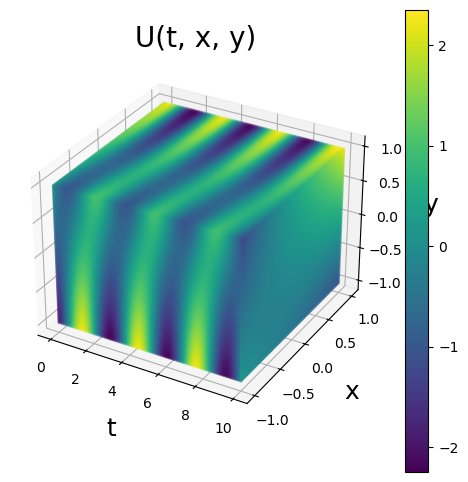

  0%|                                              | 87/50000 [00:03<25:08, 33.08it/s]

Epoch: 1/50000 --> loss: 9.48899937, error: 1.00119019
Solution:


 10%|████▍                                      | 5130/50000 [00:09<00:57, 785.69it/s]

Epoch: 5000/50000 --> loss: 1.12170351, error: 1.04569447
Solution:


 20%|████████▌                                 | 10152/50000 [00:16<00:42, 942.49it/s]

Epoch: 10000/50000 --> loss: 0.34585977, error: 0.43110147
Solution:


 30%|████████████▋                             | 15147/50000 [00:22<00:41, 849.41it/s]

Epoch: 15000/50000 --> loss: 0.38882917, error: 0.58914346
Solution:


 40%|████████████████▉                         | 20116/50000 [00:28<00:34, 856.61it/s]

Epoch: 20000/50000 --> loss: 0.01808482, error: 0.12205099
Solution:


 50%|█████████████████████                     | 25059/50000 [00:34<00:33, 746.41it/s]

Epoch: 25000/50000 --> loss: 0.00369640, error: 0.05680802
Solution:


 60%|█████████████████████████▎                | 30155/50000 [00:40<00:20, 957.23it/s]

Epoch: 30000/50000 --> loss: 0.00204773, error: 0.03353389
Solution:


 70%|█████████████████████████████▌            | 35159/50000 [00:45<00:17, 833.21it/s]

Epoch: 35000/50000 --> loss: 0.00062805, error: 0.01735706
Solution:


 80%|█████████████████████████████████▋        | 40101/50000 [00:51<00:10, 949.97it/s]

Epoch: 40000/50000 --> loss: 0.00184290, error: 0.02278144
Solution:


 90%|█████████████████████████████████████▉    | 45167/50000 [00:57<00:05, 938.00it/s]

Epoch: 45000/50000 --> loss: 0.00108136, error: 0.01532158
Solution:


100%|██████████████████████████████████████████| 50000/50000 [01:02<00:00, 795.32it/s]


Epoch: 50000/50000 --> loss: 0.00028032, error: 0.00921195
Solution:
Runtime: 1.26 ms/iter.
Solution:


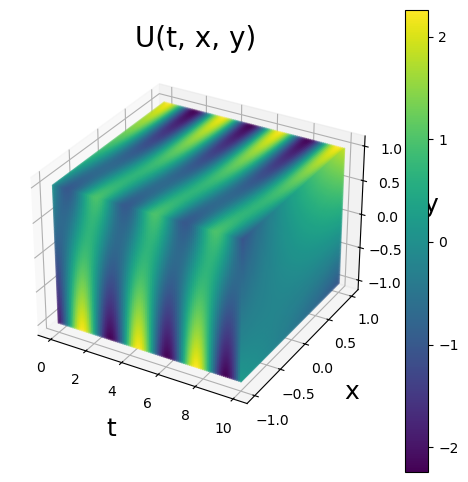

  0%|                                              | 84/50000 [00:03<26:01, 31.96it/s]

Epoch: 1/50000 --> loss: 8.12837410, error: 1.00045121
Solution:


 10%|████▍                                      | 5130/50000 [00:09<00:52, 846.70it/s]

Epoch: 5000/50000 --> loss: 1.91172218, error: 1.19427240
Solution:


 20%|████████▍                                 | 10114/50000 [00:15<00:43, 924.74it/s]

Epoch: 10000/50000 --> loss: 0.02162063, error: 0.13236758
Solution:


 30%|████████████▋                             | 15152/50000 [00:20<00:36, 949.52it/s]

Epoch: 15000/50000 --> loss: 0.00604826, error: 0.05613062
Solution:


 40%|████████████████▉                         | 20136/50000 [00:26<00:31, 952.37it/s]

Epoch: 20000/50000 --> loss: 0.00117603, error: 0.02240189
Solution:


 50%|█████████████████████                     | 25104/50000 [00:31<00:26, 950.78it/s]

Epoch: 25000/50000 --> loss: 0.00150690, error: 0.01983980
Solution:


 60%|█████████████████████████▎                | 30179/50000 [00:36<00:20, 944.23it/s]

Epoch: 30000/50000 --> loss: 0.00038616, error: 0.01270851
Solution:


 70%|█████████████████████████████▌            | 35159/50000 [00:42<00:16, 915.93it/s]

Epoch: 35000/50000 --> loss: 0.00457573, error: 0.03199744
Solution:


 80%|█████████████████████████████████▋        | 40104/50000 [00:47<00:10, 949.59it/s]

Epoch: 40000/50000 --> loss: 0.00031619, error: 0.01179925
Solution:


 90%|█████████████████████████████████████▉    | 45166/50000 [00:53<00:05, 950.00it/s]

Epoch: 45000/50000 --> loss: 0.00017785, error: 0.00844485
Solution:


100%|██████████████████████████████████████████| 50000/50000 [00:58<00:00, 857.61it/s]


Epoch: 50000/50000 --> loss: 0.00162742, error: 0.01836455
Solution:
Runtime: 1.17 ms/iter.
Solution:


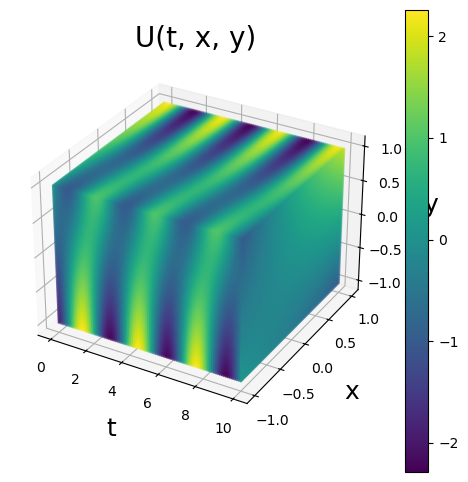

  0%|                                              | 80/50000 [00:03<28:50, 28.84it/s]

Epoch: 1/50000 --> loss: 7.73951244, error: 1.00732183
Solution:


 10%|████▍                                      | 5130/50000 [00:10<00:47, 953.11it/s]

Epoch: 5000/50000 --> loss: 2.60940552, error: 1.49240315
Solution:


 20%|████████▍                                 | 10118/50000 [00:15<00:42, 934.92it/s]

Epoch: 10000/50000 --> loss: 3.34544539, error: 1.21452498
Solution:


 30%|████████████▋                             | 15144/50000 [00:22<00:44, 777.31it/s]

Epoch: 15000/50000 --> loss: 7.90874958, error: 1.22925472
Solution:


 40%|████████████████▉                         | 20164/50000 [00:28<00:40, 738.20it/s]

Epoch: 20000/50000 --> loss: 3.12539339, error: 1.12989795
Solution:


 50%|█████████████████████                     | 25117/50000 [00:34<00:26, 925.27it/s]

Epoch: 25000/50000 --> loss: 0.42888910, error: 0.46949443
Solution:


 60%|█████████████████████████▎                | 30145/50000 [00:39<00:20, 948.53it/s]

Epoch: 30000/50000 --> loss: 0.01074895, error: 0.07021144
Solution:


 70%|█████████████████████████████▌            | 35152/50000 [00:45<00:15, 948.93it/s]

Epoch: 35000/50000 --> loss: 0.00232711, error: 0.03202122
Solution:


 80%|█████████████████████████████████▋        | 40160/50000 [00:50<00:10, 954.43it/s]

Epoch: 40000/50000 --> loss: 0.00119489, error: 0.02330642
Solution:


 90%|█████████████████████████████████████▉    | 45108/50000 [00:56<00:05, 954.76it/s]

Epoch: 45000/50000 --> loss: 0.01510976, error: 0.06877122
Solution:


100%|██████████████████████████████████████████| 50000/50000 [01:02<00:00, 804.38it/s]


Epoch: 50000/50000 --> loss: 0.00198499, error: 0.02533991
Solution:
Runtime: 1.24 ms/iter.
Solution:


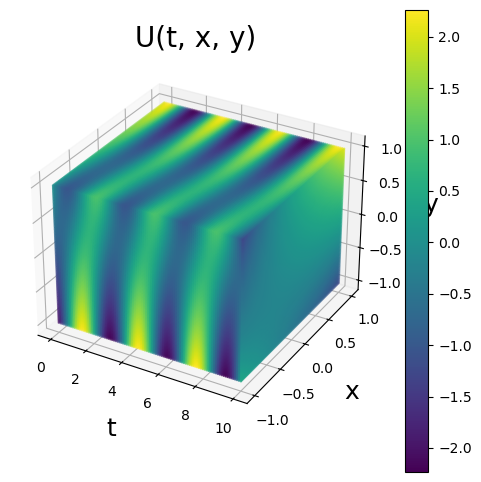

  0%|                                              | 87/50000 [00:03<25:25, 32.71it/s]

Epoch: 1/50000 --> loss: 8.42008305, error: 1.01437140
Solution:


 10%|████▍                                      | 5187/50000 [00:09<00:47, 952.10it/s]

Epoch: 5000/50000 --> loss: 0.05458234, error: 0.16598392
Solution:


 20%|████████▌                                 | 10169/50000 [00:14<00:42, 946.87it/s]

Epoch: 10000/50000 --> loss: 0.00251290, error: 0.03707815
Solution:


 30%|████████████▋                             | 15154/50000 [00:20<00:42, 825.13it/s]

Epoch: 15000/50000 --> loss: 0.00034264, error: 0.01438198
Solution:


 40%|████████████████▉                         | 20132/50000 [00:25<00:31, 935.41it/s]

Epoch: 20000/50000 --> loss: 0.01097787, error: 0.04816090
Solution:


 50%|█████████████████████                     | 25085/50000 [00:31<00:26, 936.35it/s]

Epoch: 25000/50000 --> loss: 0.00063788, error: 0.01178730
Solution:


 60%|█████████████████████████▎                | 30164/50000 [00:37<00:21, 916.83it/s]

Epoch: 30000/50000 --> loss: 0.00063281, error: 0.00995586
Solution:


 70%|█████████████████████████████▌            | 35182/50000 [00:43<00:16, 915.32it/s]

Epoch: 35000/50000 --> loss: 0.00045039, error: 0.00967069
Solution:


 80%|█████████████████████████████████▊        | 40193/50000 [00:50<00:10, 930.41it/s]

Epoch: 40000/50000 --> loss: 0.00376258, error: 0.03057850
Solution:


 90%|█████████████████████████████████████▉    | 45165/50000 [00:55<00:05, 950.21it/s]

Epoch: 45000/50000 --> loss: 0.00007143, error: 0.00423599
Solution:


100%|██████████████████████████████████████████| 50000/50000 [01:01<00:00, 813.18it/s]


Epoch: 50000/50000 --> loss: 0.00007248, error: 0.00427294
Solution:
Runtime: 1.23 ms/iter.
Solution:


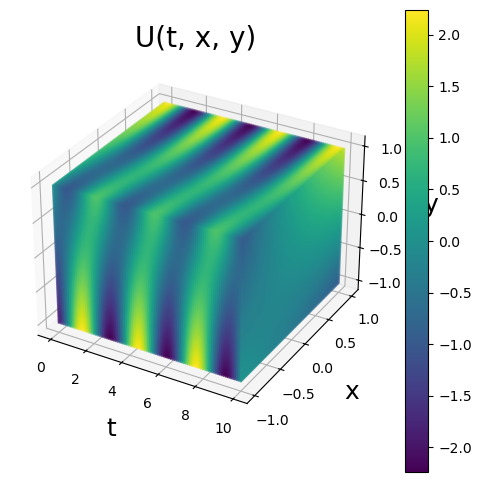

  0%|                                              | 74/50000 [00:04<38:13, 21.77it/s]

Epoch: 1/50000 --> loss: 7.72890377, error: 1.03339553
Solution:


 10%|████▍                                      | 5131/50000 [00:11<00:58, 761.22it/s]

Epoch: 5000/50000 --> loss: 2.68385458, error: 1.49466133
Solution:


 20%|████████▍                                 | 10086/50000 [00:18<01:03, 630.74it/s]

Epoch: 10000/50000 --> loss: 2.10477448, error: 1.13509631
Solution:


 30%|████████████▋                             | 15125/50000 [00:25<00:45, 762.33it/s]

Epoch: 15000/50000 --> loss: 4.84455776, error: 1.26250100
Solution:


 40%|████████████████▉                         | 20137/50000 [00:32<00:41, 716.30it/s]

Epoch: 20000/50000 --> loss: 0.07274263, error: 0.29993358
Solution:


 50%|█████████████████████                     | 25146/50000 [00:39<00:36, 685.28it/s]

Epoch: 25000/50000 --> loss: 0.05747952, error: 0.14158612
Solution:


 60%|█████████████████████████▎                | 30141/50000 [00:46<00:25, 770.44it/s]

Epoch: 30000/50000 --> loss: 0.00395482, error: 0.08737011
Solution:


 70%|█████████████████████████████▍            | 35113/50000 [00:53<00:22, 666.97it/s]

Epoch: 35000/50000 --> loss: 0.01175331, error: 0.07802380
Solution:


 80%|█████████████████████████████████▋        | 40096/50000 [01:00<00:13, 717.89it/s]

Epoch: 40000/50000 --> loss: 0.00088608, error: 0.05637600
Solution:


 90%|█████████████████████████████████████▊    | 45087/50000 [01:06<00:06, 745.65it/s]

Epoch: 45000/50000 --> loss: 0.00061994, error: 0.04268246
Solution:


100%|██████████████████████████████████████████| 50000/50000 [01:13<00:00, 676.14it/s]


Epoch: 50000/50000 --> loss: 0.00042962, error: 0.03558183
Solution:
Runtime: 1.48 ms/iter.
Solution:


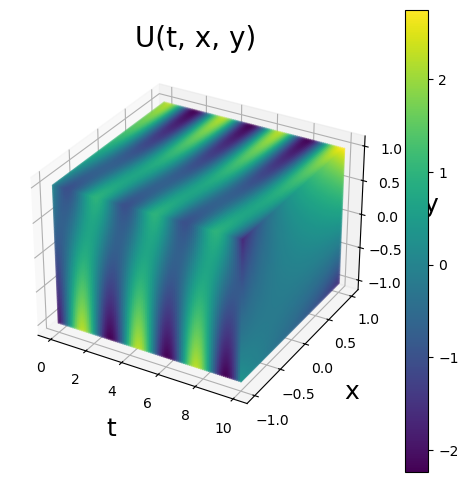

  0%|                                              | 67/50000 [00:03<32:17, 25.78it/s]

Epoch: 1/50000 --> loss: 9.56607246, error: 1.01692510
Solution:


 10%|████▍                                      | 5148/50000 [00:10<01:01, 734.16it/s]

Epoch: 5000/50000 --> loss: 2.07220697, error: 1.32897723
Solution:


 20%|████████▍                                 | 10104/50000 [00:17<00:52, 756.22it/s]

Epoch: 10000/50000 --> loss: 1.39597845, error: 1.12824559
Solution:


 30%|████████████▋                             | 15147/50000 [00:23<00:45, 767.98it/s]

Epoch: 15000/50000 --> loss: 4.34714508, error: 1.11412990
Solution:


 40%|████████████████▉                         | 20109/50000 [00:30<00:38, 767.66it/s]

Epoch: 20000/50000 --> loss: 0.15484026, error: 0.51820511
Solution:


 50%|█████████████████████                     | 25128/50000 [00:37<00:32, 769.82it/s]

Epoch: 25000/50000 --> loss: 0.04079071, error: 0.18879725
Solution:


 60%|█████████████████████████▎                | 30086/50000 [00:43<00:25, 768.96it/s]

Epoch: 30000/50000 --> loss: 0.01337553, error: 0.08088464
Solution:


 70%|█████████████████████████████▍            | 35115/50000 [00:50<00:19, 768.11it/s]

Epoch: 35000/50000 --> loss: 0.00525450, error: 0.05465081
Solution:


 80%|█████████████████████████████████▋        | 40136/50000 [00:56<00:12, 769.35it/s]

Epoch: 40000/50000 --> loss: 0.00543987, error: 0.05297401
Solution:


 90%|█████████████████████████████████████▉    | 45096/50000 [01:03<00:06, 736.35it/s]

Epoch: 45000/50000 --> loss: 0.00126105, error: 0.02447856
Solution:


100%|██████████████████████████████████████████| 50000/50000 [01:10<00:00, 710.32it/s]


Epoch: 50000/50000 --> loss: 0.00439564, error: 0.03223248
Solution:
Runtime: 1.41 ms/iter.
Solution:


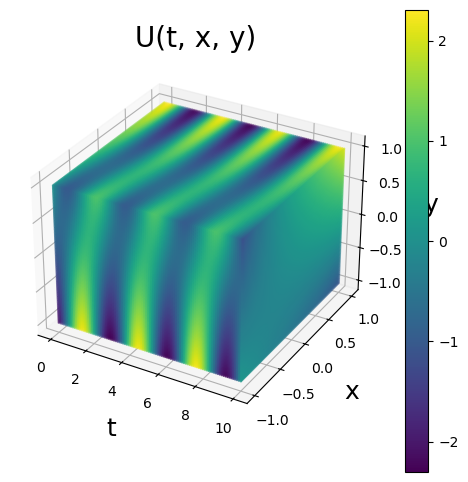

  0%|                                              | 71/50000 [00:03<29:17, 28.41it/s]

Epoch: 1/50000 --> loss: 8.07480621, error: 1.07252300
Solution:


 10%|████▍                                      | 5148/50000 [00:10<00:58, 765.70it/s]

Epoch: 5000/50000 --> loss: 6.05739021, error: 1.07668984
Solution:


 20%|████████▍                                 | 10101/50000 [00:16<00:52, 763.90it/s]

Epoch: 10000/50000 --> loss: 4.40840673, error: 1.21733773
Solution:


 30%|████████████▋                             | 15145/50000 [00:23<00:47, 731.84it/s]

Epoch: 15000/50000 --> loss: 4.98383999, error: 0.98801702
Solution:


 40%|████████████████▉                         | 20126/50000 [00:30<00:38, 767.29it/s]

Epoch: 20000/50000 --> loss: 3.28991246, error: 0.81791216
Solution:


 50%|█████████████████████                     | 25146/50000 [00:37<00:33, 742.90it/s]

Epoch: 25000/50000 --> loss: 2.60969090, error: 1.00643981
Solution:


 60%|█████████████████████████▎                | 30096/50000 [00:43<00:26, 758.06it/s]

Epoch: 30000/50000 --> loss: 4.66598034, error: 1.38549936
Solution:


 70%|█████████████████████████████▍            | 35107/50000 [00:50<00:20, 734.04it/s]

Epoch: 35000/50000 --> loss: 6.92815971, error: 1.31237113
Solution:


 80%|█████████████████████████████████▋        | 40086/50000 [00:57<00:12, 770.46it/s]

Epoch: 40000/50000 --> loss: 0.29795957, error: 0.56585395
Solution:


 90%|█████████████████████████████████████▉    | 45111/50000 [01:04<00:06, 768.63it/s]

Epoch: 45000/50000 --> loss: 0.29501036, error: 0.48856962
Solution:


100%|██████████████████████████████████████████| 50000/50000 [01:10<00:00, 708.36it/s]


Epoch: 50000/50000 --> loss: 0.45910349, error: 0.50272751
Solution:
Runtime: 1.41 ms/iter.
Solution:


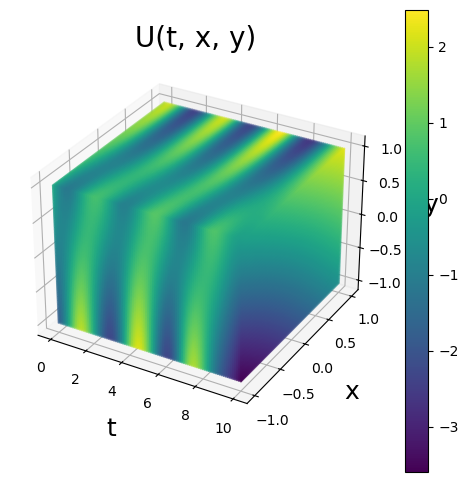

  0%|                                              | 71/50000 [00:03<30:38, 27.16it/s]

Epoch: 1/50000 --> loss: 7.72139072, error: 1.09240210
Solution:


 10%|████▍                                      | 5089/50000 [00:10<00:58, 767.15it/s]

Epoch: 5000/50000 --> loss: 5.94599915, error: 0.95396411
Solution:


 20%|████████▌                                 | 10125/50000 [00:16<00:52, 756.57it/s]

Epoch: 10000/50000 --> loss: 2.78296733, error: 1.18418801
Solution:


 30%|████████████▋                             | 15093/50000 [00:23<00:52, 661.66it/s]

Epoch: 15000/50000 --> loss: 2.01478934, error: 1.17822480
Solution:


 40%|████████████████▉                         | 20144/50000 [00:30<00:39, 761.21it/s]

Epoch: 20000/50000 --> loss: 0.78311503, error: 0.67464548
Solution:


 50%|█████████████████████                     | 25099/50000 [00:37<00:32, 768.26it/s]

Epoch: 25000/50000 --> loss: 2.46586800, error: 1.02014148
Solution:


 60%|█████████████████████████▎                | 30128/50000 [00:43<00:25, 769.59it/s]

Epoch: 30000/50000 --> loss: 1.51706243, error: 0.86799848
Solution:


 70%|█████████████████████████████▍            | 35081/50000 [00:50<00:19, 768.07it/s]

Epoch: 35000/50000 --> loss: 0.04056177, error: 0.15037221
Solution:


 80%|█████████████████████████████████▋        | 40117/50000 [00:56<00:12, 767.94it/s]

Epoch: 40000/50000 --> loss: 0.04963180, error: 0.17671897
Solution:


 90%|█████████████████████████████████████▉    | 45152/50000 [01:03<00:06, 763.21it/s]

Epoch: 45000/50000 --> loss: 0.00288158, error: 0.03133687
Solution:


100%|██████████████████████████████████████████| 50000/50000 [01:10<00:00, 713.52it/s]


Epoch: 50000/50000 --> loss: 0.00680067, error: 0.05962228
Solution:
Runtime: 1.40 ms/iter.
Solution:


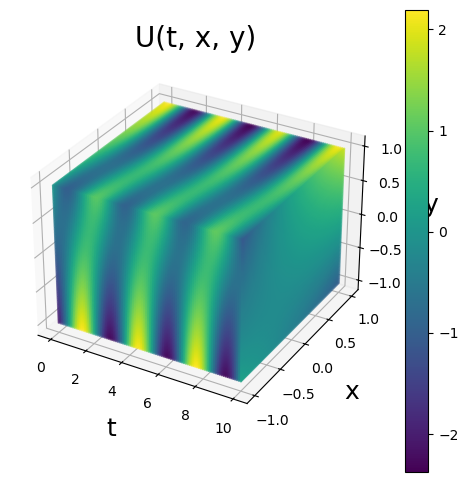

  0%|                                              | 69/50000 [00:04<34:44, 23.96it/s]

Epoch: 1/50000 --> loss: 8.46259308, error: 1.02542090
Solution:


 10%|████▍                                      | 5114/50000 [00:10<00:58, 768.77it/s]

Epoch: 5000/50000 --> loss: 4.09776020, error: 1.13629138
Solution:


 20%|████████▌                                 | 10140/50000 [00:17<00:52, 762.99it/s]

Epoch: 10000/50000 --> loss: 3.09276533, error: 1.46874702
Solution:


 30%|████████████▋                             | 15103/50000 [00:24<00:45, 769.76it/s]

Epoch: 15000/50000 --> loss: 3.39290643, error: 0.94068933
Solution:


 40%|████████████████▉                         | 20142/50000 [00:30<00:38, 769.01it/s]

Epoch: 20000/50000 --> loss: 0.70477194, error: 0.62915277
Solution:


 50%|█████████████████████                     | 25109/50000 [00:37<00:32, 770.10it/s]

Epoch: 25000/50000 --> loss: 0.37343770, error: 0.39158487
Solution:


 60%|█████████████████████████▎                | 30137/50000 [00:43<00:25, 765.66it/s]

Epoch: 30000/50000 --> loss: 1.75318587, error: 0.98463696
Solution:


 70%|█████████████████████████████▍            | 35086/50000 [00:50<00:19, 764.66it/s]

Epoch: 35000/50000 --> loss: 0.04577539, error: 0.15893137
Solution:


 80%|█████████████████████████████████▋        | 40152/50000 [00:57<00:12, 766.96it/s]

Epoch: 40000/50000 --> loss: 0.02016431, error: 0.07985353
Solution:


 90%|█████████████████████████████████████▉    | 45134/50000 [01:04<00:06, 758.43it/s]

Epoch: 45000/50000 --> loss: 0.05452674, error: 0.09995575
Solution:


100%|██████████████████████████████████████████| 50000/50000 [01:10<00:00, 708.25it/s]


Epoch: 50000/50000 --> loss: 0.00782674, error: 0.04892949
Solution:
Runtime: 1.41 ms/iter.
Solution:


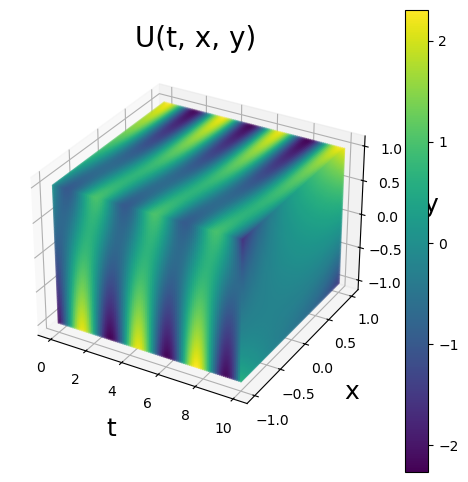

  0%|                                              | 68/50000 [00:04<40:21, 20.62it/s]

Epoch: 1/50000 --> loss: 7.75232697, error: 1.00823820
Solution:


 10%|████▎                                      | 5077/50000 [00:11<01:03, 706.04it/s]

Epoch: 5000/50000 --> loss: 3.32302761, error: 1.49983037
Solution:


 20%|████████▍                                 | 10090/50000 [00:18<00:55, 718.14it/s]

Epoch: 10000/50000 --> loss: 5.66248989, error: 1.14298964
Solution:


 30%|████████████▋                             | 15103/50000 [00:25<00:48, 719.79it/s]

Epoch: 15000/50000 --> loss: 7.36680317, error: 1.15035236
Solution:


 40%|████████████████▉                         | 20119/50000 [00:32<00:41, 717.93it/s]

Epoch: 20000/50000 --> loss: 2.59126139, error: 1.20798838
Solution:


 50%|█████████████████████                     | 25122/50000 [00:39<00:36, 679.28it/s]

Epoch: 25000/50000 --> loss: 3.73373890, error: 1.36068678
Solution:


 60%|█████████████████████████▎                | 30141/50000 [00:47<00:27, 716.71it/s]

Epoch: 30000/50000 --> loss: 0.46170118, error: 0.66823304
Solution:


 70%|█████████████████████████████▍            | 35075/50000 [00:54<00:21, 689.92it/s]

Epoch: 35000/50000 --> loss: 1.48977923, error: 1.03674817
Solution:


 80%|█████████████████████████████████▋        | 40112/50000 [01:01<00:13, 716.21it/s]

Epoch: 40000/50000 --> loss: 0.51453984, error: 0.59582263
Solution:


 90%|█████████████████████████████████████▉    | 45118/50000 [01:08<00:06, 720.06it/s]

Epoch: 45000/50000 --> loss: 0.00856314, error: 0.07119389
Solution:


100%|██████████████████████████████████████████| 50000/50000 [01:15<00:00, 661.48it/s]


Epoch: 50000/50000 --> loss: 0.00226906, error: 0.02724588
Solution:
Runtime: 1.51 ms/iter.
Solution:


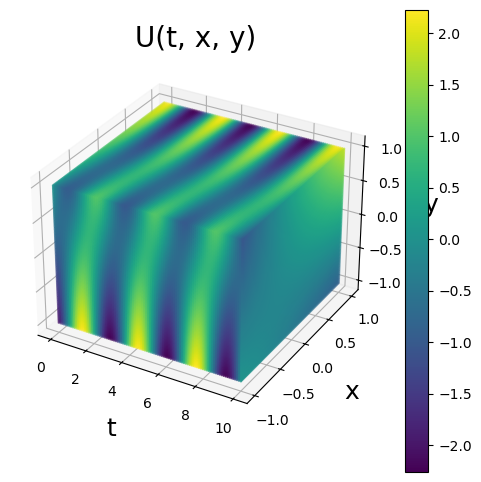

  0%|                                              | 66/50000 [00:03<32:25, 25.67it/s]

Epoch: 1/50000 --> loss: 9.48692703, error: 1.04822695
Solution:


 10%|████▍                                      | 5142/50000 [00:10<01:03, 710.52it/s]

Epoch: 5000/50000 --> loss: 4.08303833, error: 1.28530836
Solution:


 20%|████████▍                                 | 10061/50000 [00:17<01:03, 633.35it/s]

Epoch: 10000/50000 --> loss: 5.06944609, error: 1.21059072
Solution:


 30%|████████████▋                             | 15112/50000 [00:25<00:48, 716.76it/s]

Epoch: 15000/50000 --> loss: 4.25671864, error: 1.11947274
Solution:


 40%|████████████████▉                         | 20117/50000 [00:32<00:41, 718.57it/s]

Epoch: 20000/50000 --> loss: 2.18321586, error: 1.53520131
Solution:


 50%|█████████████████████                     | 25092/50000 [00:39<00:35, 708.82it/s]

Epoch: 25000/50000 --> loss: 1.26635671, error: 1.14443696
Solution:


 60%|█████████████████████████▎                | 30097/50000 [00:46<00:27, 718.00it/s]

Epoch: 30000/50000 --> loss: 0.04505790, error: 0.21410926
Solution:


 70%|█████████████████████████████▍            | 35076/50000 [00:53<00:21, 691.62it/s]

Epoch: 35000/50000 --> loss: 0.05581521, error: 0.20034543
Solution:


 80%|█████████████████████████████████▋        | 40077/50000 [01:00<00:14, 682.53it/s]

Epoch: 40000/50000 --> loss: 0.00634310, error: 0.08058315
Solution:


 90%|█████████████████████████████████████▉    | 45098/50000 [01:07<00:06, 717.69it/s]

Epoch: 45000/50000 --> loss: 0.00584094, error: 0.06138234
Solution:


100%|██████████████████████████████████████████| 50000/50000 [01:15<00:00, 664.91it/s]


Epoch: 50000/50000 --> loss: 0.00233172, error: 0.05173320
Solution:
Runtime: 1.50 ms/iter.
Solution:


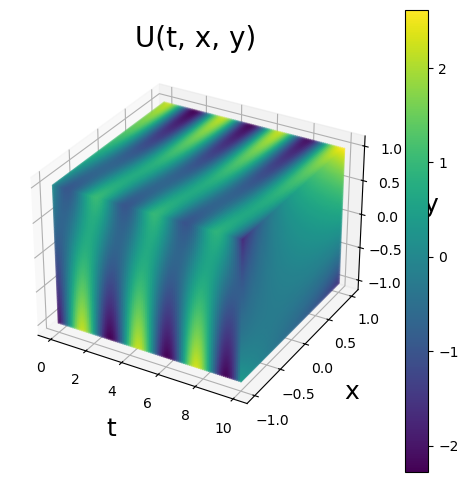

  0%|                                              | 66/50000 [00:03<33:47, 24.63it/s]

Epoch: 1/50000 --> loss: 8.11590481, error: 1.01506734
Solution:


 10%|████▍                                      | 5131/50000 [00:10<01:02, 715.99it/s]

Epoch: 5000/50000 --> loss: 6.34830475, error: 1.10814834
Solution:


 20%|████████▌                                 | 10145/50000 [00:17<00:55, 718.17it/s]

Epoch: 10000/50000 --> loss: 6.12735844, error: 1.10098231
Solution:


 30%|████████████▋                             | 15088/50000 [00:24<00:48, 721.52it/s]

Epoch: 15000/50000 --> loss: 5.86784315, error: 1.08902991
Solution:


 40%|████████████████▊                         | 20086/50000 [00:31<00:41, 721.53it/s]

Epoch: 20000/50000 --> loss: 5.30796051, error: 1.04907286
Solution:


 50%|█████████████████████                     | 25142/50000 [00:39<00:34, 720.57it/s]

Epoch: 25000/50000 --> loss: 3.28393984, error: 1.42016160
Solution:


 60%|█████████████████████████▎                | 30143/50000 [00:46<00:27, 716.63it/s]

Epoch: 30000/50000 --> loss: 2.62919235, error: 1.04227793
Solution:


 70%|█████████████████████████████▌            | 35135/50000 [00:53<00:21, 689.77it/s]

Epoch: 35000/50000 --> loss: 3.38853502, error: 1.07349801
Solution:


 80%|█████████████████████████████████▋        | 40080/50000 [01:00<00:13, 723.15it/s]

Epoch: 40000/50000 --> loss: 3.95883942, error: 1.29221880
Solution:


 90%|█████████████████████████████████████▊    | 45080/50000 [01:07<00:06, 721.93it/s]

Epoch: 45000/50000 --> loss: 0.03235776, error: 0.14818799
Solution:


100%|██████████████████████████████████████████| 50000/50000 [01:14<00:00, 669.80it/s]


Epoch: 50000/50000 --> loss: 0.00500773, error: 0.04437290
Solution:
Runtime: 1.49 ms/iter.
Solution:


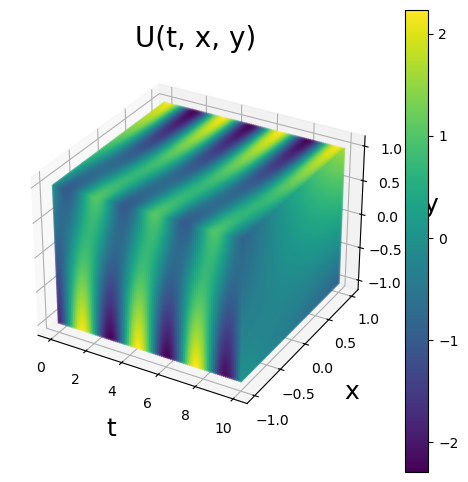

  0%|                                              | 66/50000 [00:03<34:28, 24.15it/s]

Epoch: 1/50000 --> loss: 7.76223993, error: 1.02613735
Solution:


 10%|████▍                                      | 5101/50000 [00:11<01:09, 650.42it/s]

Epoch: 5000/50000 --> loss: 5.97171068, error: 0.95115572
Solution:


 20%|████████▍                                 | 10117/50000 [00:18<00:55, 717.98it/s]

Epoch: 10000/50000 --> loss: 2.73629999, error: 1.41959059
Solution:


 30%|████████████▋                             | 15101/50000 [00:25<00:50, 690.26it/s]

Epoch: 15000/50000 --> loss: 2.70919228, error: 1.37506557
Solution:


 40%|████████████████▊                         | 20083/50000 [00:32<00:42, 707.19it/s]

Epoch: 20000/50000 --> loss: 3.71906114, error: 1.32998359
Solution:


 50%|█████████████████████                     | 25087/50000 [00:39<00:34, 717.93it/s]

Epoch: 25000/50000 --> loss: 5.26911163, error: 1.11485314
Solution:


 60%|█████████████████████████▎                | 30136/50000 [00:47<00:28, 707.17it/s]

Epoch: 30000/50000 --> loss: 0.16227087, error: 0.21806280
Solution:


 70%|█████████████████████████████▌            | 35124/50000 [00:54<00:20, 714.27it/s]

Epoch: 35000/50000 --> loss: 1.25881636, error: 0.77682036
Solution:


 80%|█████████████████████████████████▋        | 40104/50000 [01:01<00:13, 717.41it/s]

Epoch: 40000/50000 --> loss: 0.01998677, error: 0.10806583
Solution:


 90%|█████████████████████████████████████▉    | 45133/50000 [01:08<00:06, 712.22it/s]

Epoch: 45000/50000 --> loss: 0.02905859, error: 0.07004708
Solution:


100%|██████████████████████████████████████████| 50000/50000 [01:15<00:00, 665.78it/s]


Epoch: 50000/50000 --> loss: 0.00948716, error: 0.04298842
Solution:
Runtime: 1.50 ms/iter.
Solution:


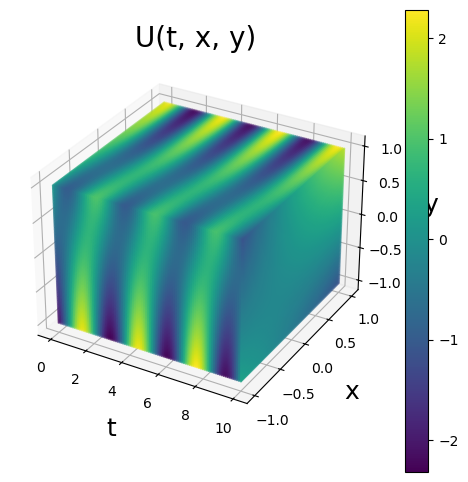

  0%|                                              | 66/50000 [00:03<33:48, 24.62it/s]

Epoch: 1/50000 --> loss: 8.51758194, error: 1.02119708
Solution:


 10%|████▍                                      | 5140/50000 [00:10<01:02, 713.87it/s]

Epoch: 5000/50000 --> loss: 3.03556442, error: 1.44379735
Solution:


 20%|████████▍                                 | 10092/50000 [00:17<00:55, 722.71it/s]

Epoch: 10000/50000 --> loss: 3.08033252, error: 1.17166793
Solution:


 30%|████████████▋                             | 15101/50000 [00:24<00:49, 706.69it/s]

Epoch: 15000/50000 --> loss: 6.04549694, error: 1.21148849
Solution:


 40%|████████████████▉                         | 20103/50000 [00:31<00:41, 722.48it/s]

Epoch: 20000/50000 --> loss: 1.05031753, error: 0.78045398
Solution:


 50%|█████████████████████                     | 25074/50000 [00:38<00:34, 714.34it/s]

Epoch: 25000/50000 --> loss: 1.30457211, error: 0.85133457
Solution:


 60%|█████████████████████████▎                | 30076/50000 [00:46<00:27, 717.59it/s]

Epoch: 30000/50000 --> loss: 5.23106575, error: 1.26298165
Solution:


 70%|█████████████████████████████▍            | 35097/50000 [00:53<00:20, 720.18it/s]

Epoch: 35000/50000 --> loss: 7.44834423, error: 1.26799905
Solution:


 80%|█████████████████████████████████▋        | 40084/50000 [01:00<00:13, 718.91it/s]

Epoch: 40000/50000 --> loss: 0.75017464, error: 0.65127748
Solution:


 90%|█████████████████████████████████████▉    | 45115/50000 [01:07<00:06, 719.74it/s]

Epoch: 45000/50000 --> loss: 4.22194386, error: 1.45724654
Solution:


100%|██████████████████████████████████████████| 50000/50000 [01:13<00:00, 676.94it/s]


Epoch: 50000/50000 --> loss: 0.13612637, error: 0.35819149
Solution:
Runtime: 1.48 ms/iter.
Solution:


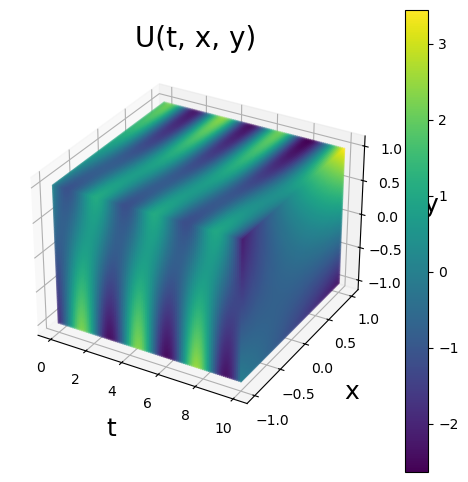

In [7]:
import numpy as np
for i in ["CPPINN","TTPINN","TuckerPINN"]:
    for j in range(5):
        logs=main(mode=i,NC=64, NI=64, NB=64, NC_TEST=100, SEED=444+j, LR=1e-3, EPOCHS=50000, N_LAYERS=4, FEATURES=32, LOG_ITER=5000)
        logs = np.array(logs)
        np.savetxt("Rank32/{}_{}_results".format(i,j),logs)
        